# baseline

將`關鍵字`比對換成`向量相似度`比對。

> 請將目前使用關鍵字比對的 route_by_query，改為使用向量相似度進行分類，並設一個合理的相似度門檻，根據檢索結果的分數判斷是否走 RAG 流程。  
例如用向量相似度及自訂 threshold 決定要不要分到 retriever。

> Hint：similarity_search_with_score(...)  
可參考去年的讀書會 R4：向量資料庫的基本操作

In [1]:
! pip install -q langchain langgraph transformers bitsandbytes langchain-huggingface langchain-community chromadb langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.4 MB/s eta 0:00:00

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.runnables import RunnableLambda
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

from typing_extensions import TypedDict, List
from typing import Annotated
import os, getpass
from IPython.display import Image, display

In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

# LLM
model_name = "gemini-2.5-flash-preview-04-17"
gemini_lm = ChatGoogleGenerativeAI(model=model_name)
llm = gemini_lm

GOOGLE_API_KEY: ··········


In [4]:
# 定義 LangGraph 的 State 結構
class RAGState(TypedDict):
    query: str
    docs: List[Document]
    answer: str

In [5]:
docs_text = """
火影代數	姓名	師傅	徒弟
初代	千手柱間	無明確記載	猿飛日斬、水戶門炎、轉寢小春
二代	千手扉間	千手柱間（兄長）	猿飛日斬、志村團藏、宇智波鏡等
三代	猿飛日斬	千手柱間、千手扉間	自來也、大蛇丸、千手綱手（傳說三忍）
四代	波風湊	自來也	旗木卡卡西、宇智波帶土、野原琳
五代	千手綱手	猿飛日斬	春野櫻、志乃等（主要為春野櫻）
六代	旗木卡卡西	波風湊	漩渦鳴人、宇智波佐助、春野櫻（第七班）
七代	漩渦鳴人	自來也、旗木卡卡西	木葉丸等（主要為木葉丸）
"""

docs = [Document(page_content=txt.strip()) for txt in docs_text.strip().split("\n\n")]

# chromadb 預設使用的大型語言模型為 "all-MiniLM-L6-v2"，由於該大型語言模型不支持中文，所以將模型替換為 "infgrad/stella-base-zh-v3-1792d"，並對 embedding 進行量化
embedding_model = HuggingFaceEmbeddings(
    model_name="infgrad/stella-base-zh-v3-1792d",
    encode_kwargs={"normalize_embeddings": True}
)

routing_docs = {
    "naruto": Document(page_content=docs_text),
    "general": Document(page_content="一般性問題、非火影忍者相關問題。")
}

vectorstore = Chroma.from_documents(
    documents=list(routing_docs.values()),
    embedding=embedding_model,
    collection_name="routing_collection",
    collection_metadata={"hnsw:space": "cosine"}
)

<ipython-input-5-649b959d5ef9>:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/311 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/32.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/408M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at infgrad/stella-base-zh-v3-1792d and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.51M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/408M [00:00<?, ?B/s]

In [8]:
def retrieve_node(state: RAGState) -> RAGState:
    query = state["query"]
    # similarity_search 距離越小越相似
    docs = vectorstore.similarity_search(query, k=3)
    return {"query": query, "docs": docs, "answer": ""}

def generate_node(state: RAGState) -> RAGState:
    query, docs = state["query"], state["docs"]
    context = "\n".join([d.page_content for d in docs])
    prompt = (
        f"你是一個知識型助手，請根據以下內容回答問題：\n\n"
        f"內容：{context}\n\n"
        f"問題：{query}\n\n回答："
    )
    # output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    output = llm.invoke(prompt).content
    return {"query": query, "docs": docs, "answer": output}

def direct_generate_node(state: RAGState) -> RAGState:
    query = state["query"]
    prompt = f"請回答以下問題：{query}\n\n回答："
    # output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    output = llm.invoke(prompt).content
    return {"query": query, "docs": [], "answer": output}

def route_by_query(state):
    query = state["query"]
    results = vectorstore.similarity_search_with_score(query, k=1)

    if results:
        most_similar_doc, score = results[0]
        if docs_text == most_similar_doc.page_content:
            choice = "naruto"
        else:
            choice = "general"
    else:
        choice = "general"

    print(f"跑到 → {choice} (相似度分數: {score:.4f})")
    return choice

In [9]:
# 建立 LangGraph 流程圖
graph_builder = StateGraph(RAGState)

graph_builder.set_entry_point("condition")
graph_builder.add_node("condition", RunnableLambda(lambda x: x))  # 進來就分流，不改變內容
graph_builder.add_node("retriever", RunnableLambda(retrieve_node))
graph_builder.add_node("generator", RunnableLambda(generate_node))
graph_builder.add_node("direct_generator", RunnableLambda(direct_generate_node))

# 設定條件分流
graph_builder.add_conditional_edges(
    source="condition",
    path=RunnableLambda(route_by_query),
    path_map={
        "naruto": "retriever",
        "general": "direct_generator",
    }
)

# 接下來的正常連接
graph_builder.add_edge("retriever", "generator")
graph_builder.add_edge("generator", END)
graph_builder.add_edge("direct_generator", END)

# 編譯 Graph
graph = graph_builder.compile()

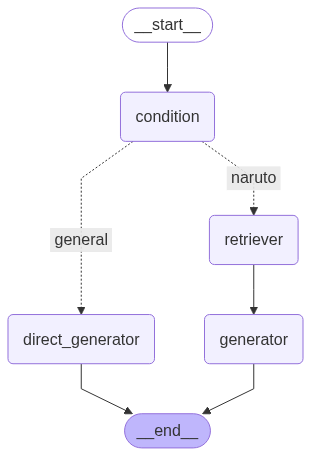

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [11]:
print("開始對話吧（輸入 q 結束）")

while True:
    user_input = input("使用者: ")
    if user_input.strip().lower() in ["q", "quit", "exit"]:
        print("掰啦！")
        break

    init_state: RAGState = {
        "query": user_input,
        "docs": [],
        "answer": ""
    }

    result = graph.invoke(init_state)
    raw_output = result["answer"]

    answer_text = raw_output.split("回答：")[-1].strip()
    print("回答：", answer_text)
    print("===" * 20, "\n")

開始對話吧（輸入 q 結束）
使用者: 第四代火影是誰?
跑到 → naruto (相似度分數: 0.3088)
回答： 根據提供的內容，第四代火影是波風湊。

使用者: 相對論是誰發明的嗎?
跑到 → general (相似度分數: 0.6275)
回答： 是的，相對論主要是由**阿爾伯特·愛因斯坦（Albert Einstein）**提出的。

他先後建立了：

1.  **狹義相對論 (Special Relativity)**：於1905年提出。
2.  **廣義相對論 (General Relativity)**：於1915年完成。

因此，阿爾伯特·愛因斯坦被公認為相對論的創始人。

使用者: q
掰啦！


# advance

改成能支援多輪問答（Multi-turn RAG），並能根據前面的query判斷問題。

> 請將 RAGState 加入 history 欄位，並在生成回答時，將歷史對話與當前問題一起組成 prompt。

> Hint：
```
class MultiTurnRAGState(TypedDict):  
    history: List[str]  
    query: str  
    docs: List[Document]  
    answer: str
```



In [16]:
# 定義 LangGraph 的 State 結構
class RAGState(TypedDict):
    history: List[str]
    query: str
    docs: List[Document]
    answer: str

# class RAGState(TypedDict):
#     query: str
#     docs: List[Document]
#     answer: str

In [13]:
docs_text = """
火影代數	姓名	師傅	徒弟
初代	千手柱間	無明確記載	猿飛日斬、水戶門炎、轉寢小春
二代	千手扉間	千手柱間（兄長）	猿飛日斬、志村團藏、宇智波鏡等
三代	猿飛日斬	千手柱間、千手扉間	自來也、大蛇丸、千手綱手（傳說三忍）
四代	波風湊	自來也	旗木卡卡西、宇智波帶土、野原琳
五代	千手綱手	猿飛日斬	春野櫻、志乃等（主要為春野櫻）
六代	旗木卡卡西	波風湊	漩渦鳴人、宇智波佐助、春野櫻（第七班）
七代	漩渦鳴人	自來也、旗木卡卡西	木葉丸等（主要為木葉丸）
"""

docs = [Document(page_content=txt.strip()) for txt in docs_text.strip().split("\n\n")]

# chromadb 預設使用的大型語言模型為 "all-MiniLM-L6-v2"，由於該大型語言模型不支持中文，所以將模型替換為 "infgrad/stella-base-zh-v3-1792d"，並對 embedding 進行量化
embedding_model = HuggingFaceEmbeddings(
    model_name="infgrad/stella-base-zh-v3-1792d",
    encode_kwargs={"normalize_embeddings": True}
)

routing_docs = {
    "naruto": Document(page_content=docs_text),
    "general": Document(page_content="一般性問題、非火影忍者相關問題。")
}

vectorstore = Chroma.from_documents(
    documents=list(routing_docs.values()),
    embedding=embedding_model,
    collection_name="routing_collection",
    collection_metadata={"hnsw:space": "cosine"}
)

Some weights of BertModel were not initialized from the model checkpoint at infgrad/stella-base-zh-v3-1792d and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
def retrieve_node(state: RAGState) -> RAGState:
    query = state["query"]
    docs = vectorstore.similarity_search(query, k=3)
    # similarity_search 距離越小越相似
    return {"query": query, "docs": docs, "answer": "", "history": state["history"]}


def generate_node(state: RAGState) -> RAGState:
    query, docs, history = state["query"], state["docs"], state["history"]
    context = "\n".join([d.page_content for d in docs])
    prompt = (
        f"你是一個知識型助手，請根據以下內容回答問題：\n\n"
        f"對話歷史：\n{history}\n\n"
        f"內容：{context}\n\n"
        f"問題：{query}\n\n回答："
    )
    # output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    output = llm.invoke(prompt).content
    return {"query": query, "docs": docs, "answer": output, "history": history}

def direct_generate_node(state: RAGState) -> RAGState:
    query, history = state["query"], state["history"]
    prompt = (
        f"請回答以下問題：{query}\n\n回答："
        f"對話歷史：\n{history}\n\n"
    )
    # output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    output = llm.invoke(prompt).content
    return {"query": query, "docs": [], "answer": output, "history": history}

def route_by_query(state):
    query = state["query"]
    results = vectorstore.similarity_search_with_score(query, k=1)

    if results:
        most_similar_doc, score = results[0]
        if docs_text == most_similar_doc.page_content:
            choice = "naruto"
        else:
            choice = "general"
    else:
        choice = "general"

    print(f"跑到 → {choice} (相似度分數: {score:.4f})")
    return choice

In [29]:
# 建立 LangGraph 流程圖
graph_builder = StateGraph(RAGState)

graph_builder.set_entry_point("condition")
graph_builder.add_node("condition", RunnableLambda(lambda x: x))  # 進來就分流，不改變內容
graph_builder.add_node("retriever", RunnableLambda(retrieve_node))
graph_builder.add_node("generator", RunnableLambda(generate_node))
graph_builder.add_node("direct_generator", RunnableLambda(direct_generate_node))

# 設定條件分流
graph_builder.add_conditional_edges(
    source="condition",
    path=RunnableLambda(route_by_query),
    path_map={
        "naruto": "retriever",
        "general": "direct_generator",
    }
)

# 接下來的正常連接
graph_builder.add_edge("retriever", "generator")
graph_builder.add_edge("generator", END)
graph_builder.add_edge("direct_generator", END)

# 編譯 Graph
graph = graph_builder.compile()

In [30]:
global_history: List[str] = []

print("開始對話吧（輸入 q 結束）")
while True:
    user_input = input("使用者: ")
    if user_input.strip().lower() in ["q", "quit", "exit"]:
        print("掰啦！")
        break

    state = {"history": "|".join(global_history), "query": user_input}
    print(state)
    result = graph.invoke(state)
    answer = result["answer"].split("回答：")[-1].strip()
    print("AI 助理:", answer)
    print("===" * 60, "\n")

    global_history.append(user_input)
    global_history.append(answer)

開始對話吧（輸入 q 結束）
使用者: 第四代火影是誰?
{'history': '', 'query': '第四代火影是誰?'}
跑到 → naruto (相似度分數: 0.3088)
AI 助理: 根據提供的內容，第四代火影是**波風湊**。

使用者: 他的師父是誰?
{'history': '第四代火影是誰?|根據提供的內容，第四代火影是**波風湊**。', 'query': '他的師父是誰?'}
跑到 → naruto (相似度分數: 0.4728)
AI 助理: 根據提供的內容，波風湊的師父是**自來也**。

使用者: q
掰啦！
